<a href="https://colab.research.google.com/github/tanvircr7/meh/blob/master/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Dependencies**

In [ ]:
# # Install dependencies (this is mostly for Google Colab, as the other dependences are available by default in Colab)
# try:
#   import datasets, evaluate, accelerate
#   import gradio as gr
# except ModuleNotFoundError:
#   !pip install -U datasets evaluate accelerate gradio # -U stands for "upgrade" so we'll get the latest version by default
#   import datasets, evaluate, accelerate
#   import gradio as gr

try:
  import datasets, evaluate, accelerate
  import gradio as gr
except ModuleNotFoundError:
  !pip install -U datasets evaluate accelerate gradio
  import datasets, evaluate, accelerate
  import gradio as gr


import random

import numpy as np
import pandas as pd

import torch
import transformers

print(f"Using transformers version: {transformers.__version__}")
print(f"Using datasets version: {datasets.__version__}")
print(f"Using torch version: {torch.__version__}")

# **Hugging Face Token**

In [ ]:
from google.colab import userdata
HF_TOKEN_MASTER = userdata.get('HF_TOKEN_MASTER')
HF_TOKEN_MASTER

# **Create Dataset**

In [ ]:
# make my own dataset on huggingface using mistral api

# **Getting Dataset**

In [ ]:

from datasets import load_dataset
dataset = load_dataset(path="mrdbourke/learn_hf_food_not_food_image_captions")
dataset

In [ ]:
# dataset['test']

# ***EDA***

In [ ]:
dataset['train'][0]

In [ ]:
import random
random_idx = random.sample(range(len(dataset['train'])), 5)
print(random_idx)
print('-----------------')
random_samples = dataset['train'][random_idx]
print(random_samples)
print('-----------------')

print(f"[INFO] Random Samples from dataset:\n")
for text, label in zip(random_samples['text'], random_samples['label']):
  print(f"Text: {text} | Label: {label}")

In [ ]:
dataset['train'].unique('label')

In [ ]:
from collections import Counter
c = Counter(dataset['train']['label'])
c

In [ ]:
# Dataset into Dataframe
food_df = pd.DataFrame(dataset['train'])
food_df

In [ ]:
food_df['label'].value_counts()

# **Prep Dataset for Text Classification**

In [ ]:
dataset['train'].unique('label')

In [ ]:
# mappings from dataset
id2Label = {idx: label for idx, label in enumerate(reversed(dataset['train'].unique('label')))}
id2Label

In [ ]:
id2Label = {}
for idx, label in enumerate(reversed(dataset['train'].unique('label'))):
  print(idx, label)
  id2Label[idx]=label


In [ ]:
id2Label

In [ ]:
label2Id = {label: idx for idx, label in id2Label.items()}
label2Id

now map labels to the numbers

In [ ]:
def map_label_to_number(example):
  example['label'] = label2Id[example['label']]
  return example

example_sample = {'text': 'love blueberry pie', 'label': 'food'}
map_label_to_number(example_sample)

In [ ]:
# map our entire dataset labels to numbers using MAP
# dataset.map
dataset = dataset['train'].map(map_label_to_number)
dataset[:5]

In [ ]:


dataset = dataset.train_test_split(test_size=0.2, seed=42)
dataset

In [ ]:
random_idx_train = random.randint(0, len(dataset['train']))
random_sample_train = dataset['train'][random_idx_train]
random_sample_train

In [ ]:
random_idx_test = random.randint(0, len(dataset['test']))
random_sample_test = dataset['train'][random_idx_test]
random_sample_test

# ***Tokenize***

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path="distilbert/distilbert-base-uncased", use_fast=True)
tokenizer

In [ ]:
# test out tokenizer
tokenizer('How are you?')

# ***explore tokenizer***

In [ ]:
lenght_of_tokenizer_vocab = len(tokenizer.vocab)
print(f"[INFO] number of items in our tokenizer vocab: {lenght_of_tokenizer_vocab}")
max_tokenizer_input_sequence_length = tokenizer.model_max_length
print(f"[INFO] Max tokenizer input sequence length: {max_tokenizer_input_sequence_length}")

In [ ]:
tokenizer.vocab['hasan']

In [ ]:
tokenizer('hasan')

In [ ]:
tokenizer.convert_ids_to_tokens(tokenizer('hasan').input_ids)

if the tokenizer deosn't know a word..

classification token word seprator token


In [ ]:
sorted(tokenizer.vocab.items())[:5]

In [ ]:
import random
random.sample(tokenizer.vocab.items(), k=5)

# ***Making a preprocessing function to tokenize text***

In [ ]:
def tokenize_text(examples):
  """
  Tokenize given example text and return tokenized text
  """
  return tokenizer(examples['text'],
                   padding=True,
                   truncation=True)

In [ ]:
example_sample_2 = {'text': 'I love pizza', 'label': 1}
tokenize_text(example_sample_2)

In [ ]:
long_text = 'I love pizza'*1000
len(long_text)

In [ ]:
tokenize_long_text = tokenize_text({'text': long_text, 'label': 1})
len(tokenize_long_text['input_ids'])

In [ ]:
tokenized_dataset = dataset.map(function=tokenize_text,
                                batched=True,
                                batch_size=1000)
tokenized_dataset

In [ ]:
# Get two samples from tokenized dataset
train_tokenized_sample = tokenized_dataset['train'][0]
test_tokenized_sample = tokenized_dataset['test'][0]

for key in train_tokenized_sample.keys():
  print(f"[INFO] {key}")
  print(f"Train sample: {train_tokenized_sample[key]}")
  print(f"Test sampel: {test_tokenized_sample[key]}")

# ***Evaluation Meric***

In [ ]:
# import evaluate
# import numpy as np
# from typing import Tuple

# accuracy_metric = evaluate.load("accuracy")
# def compute_accuracy(predictions_and_labels: Tuple[np.array, np.array]):
#   """
#   Computes the accuracy of a model by comparing predictions and labels
#   """
#   predictions, labels = predictions_and_labels
#   return accuracy_metric.compute(predictions=predictions, references=labels)

In [ ]:
example_preds_all_correct = np.array([0,0,0,0,0,0,0,0,0,0])
example_preds_one_incorrect = np.array([0,0,0,0,0,1,0,0,0,0])
example_labels = np.array([0,0,0,0,0,0,0,0,0,0])

print(f"Accuracy when all predictions are correct: {compute_accuracy((example_preds_all_correct, example_labels))}")
print(f"Accuracy when one prediction is incorrect: {compute_accuracy((example_preds_one_incorrect, example_labels))}")

1. ✅ Create and preprocess data.
2. Define the model we’d like use with transformers.
3. AutoModelForSequenceClassification (or another similar model class).
4. Define training arguments (these are hyperparameters for our model) with transformers.TrainingArguments.
5. Pass TrainingArguments from 3 and target datasets to an instance of transformers.Trainer.
6. Train the model by calling Trainer.train().
7. Save the model (to our local machine or to the Hugging Face Hub).
8. Evaluate the trained model by making and inspecting predctions on the test data.
9. Turn the model into a shareable demo.

# ***Setup Model for Training***

In [47]:
# Get id and label mappings
print(f"id2label: {id2Label}")
print(f"label2id: {label2Id}")

id2label: {0: 'not_food', 1: 'food'}
label2id: {'not_food': 0, 'food': 1}


In [48]:
from transformers import AutoModelForSequenceClassification

# setup model for fine-tuning with classification head (top layers of network)
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path = "distilbert/distilbert-base-uncased",
    num_labels = 2,
    id2label = id2Label,
    label2id = label2Id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
test_sample = tokenized_dataset['train'][0]


In [50]:
# model(**test_sample)

In [51]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

create a directory for saving models

In [52]:
# create model output directory
from pathlib import Path

models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

model_save_name = "learn_hf_food_not_food_text_classifier-distilbert-base-uncased"

model_save_dir = Path(models_dir, model_save_name)

model_save_dir

PosixPath('models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased')

In [53]:
def count_params(model):
  trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
  total_parameters = sum(p.numel() for p in model.parameters())
  return {"trainable_parameters": trainable_parameters, "total_parameters": total_parameters}
count_params(model)

{'trainable_parameters': 66955010, 'total_parameters': 66955010}

# ***Training Arguments***

1. ✅ Create and preprocess data.
2. ✅ Define the model we’d like use with transformers.
3. AutoModelForSequenceClassification (or another similar model class).
4. Define training arguments (these are hyperparameters for our model) with transformers.TrainingArguments.
5. Pass TrainingArguments from 3 and target datasets to an instance of transformers.Trainer.
6. Train the model by calling Trainer.train().
7. Save the model (to our local machine or to the Hugging Face Hub).
8. Evaluate the trained model by making and inspecting predctions on the test data.
9. Turn the model into a shareable demo.

In [54]:
from transformers import TrainingArguments

print(f"[INFO] Saving model checkpoints to: {model_save_dir}")

training_args = TrainingArguments(
    output_dir = model_save_dir,
    learning_rate = 0.0001,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    use_cpu=False,
    seed=42,
    load_best_model_at_end=True,
    logging_strategy="epoch",
    report_to="none",
    hub_private_repo=False,
)


[INFO] Saving model checkpoints to: models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased


# ***Trainer***

1. ✅ Create and preprocess data.
2. ✅ Define the model we’d like use with transformers.
3. ✅ AutoModelForSequenceClassification (or another similar model class).
4. Define training arguments (these are hyperparameters for our model) with transformers.TrainingArguments.
5. Pass TrainingArguments from 3 and target datasets to an instance of transformers.Trainer.
6. Train the model by calling Trainer.train().
7. Save the model (to our local machine or to the Hugging Face Hub).
8. Evaluate the trained model by making and inspecting predctions on the test data.
9. Turn the model into a shareable demo.

In [55]:
# OUT OF FLOW
# Redoing compute accuracy to fix error
import evaluate
import numpy as np
from typing import Tuple

accuracy_metric = evaluate.load("accuracy")
def compute_accuracy(predictions_and_labels: Tuple[np.array, np.array]):
  """
  Computes the accuracy of a model by comparing predictions and labels
  """
  predictions, labels = predictions_and_labels

  if len(predictions.shape) >= 2:
    print(f"pred shape {predictions.shape}")
    predictions = np.argmax(predictions, axis=1)

  return accuracy_metric.compute(predictions=predictions, references=labels)

In [56]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["train"],
    tokenizer=tokenizer,
    compute_metrics=compute_accuracy,
)

# ***Training our text-classification model***

1. ✅ Create and preprocess data.
2. ✅ Define the model we’d like use with transformers.
3. ✅ AutoModelForSequenceClassification (or another similar model class).
4. ✅ Define training arguments (these are hyperparameters for our model) with transformers.TrainingArguments.
5. ✅ Pass TrainingArguments from 3 and target datasets to an instance of transformers.Trainer.
6. Train the model by calling Trainer.train().
7. Save the model (to our local machine or to the Hugging Face Hub).
8. Evaluate the trained model by making and inspecting predctions on the test data.
9. Turn the model into a shareable demo.

If you get the ERROR:
ValueError                                Traceback (most recent call last)
<ipython-input-48-c1b403878abf> in <cell line: 1>()
----> 1 results = trainer.train()

8 frames
/usr/local/lib/python3.10/dist-packages/evaluate/module.py in add_batch(self, predictions, references, **kwargs)
    544                     f"Input references: {summarize_if_long_list(references)}"
    545                 )
--> 546             raise ValueError(error_msg) from None
    547
    548     def add(self, *, prediction=None, reference=None, **kwargs):

ValueError: Predictions and/or references don't match the expected format.
Expected format: {'predictions': Value(dtype='int32', id=None), 'references': Value(dtype='int32', id=None)},
Input predictions: [[ 1.3885518 -1.3348335]

In [57]:
input_predictions = np.array([[ 1.3885518, -1.3348335]])
input_references = np.array([1])
# we were having shape mismatch
# fix it by argmaxing value 1 and 2
# we're gonna use below code snippet to fix things
print(len(input_predictions.shape))
if len(input_predictions.shape) >= 2:
  input_predictions = np.argmax(input_predictions, axis=1)

print(input_predictions)

2
[0]


In [58]:
import evaluate
import numpy as np
from typing import Tuple

accuracy_metric = evaluate.load("accuracy")
def compute_accuracy(predictions_and_labels: Tuple[np.array, np.array]):
  """
  Computes the accuracy of a model by comparing predictions and labels
  """
  predictions, labels = predictions_and_labels

  if len(predictions.shape) >= 2:
    print(f"pred shape {predictions.shape}")
    predictions = np.argmax(predictions, axis=1)

  return accuracy_metric.compute(predictions=predictions, references=labels)

In [59]:
compute_accuracy(predictions_and_labels=(input_predictions, input_references))

{'accuracy': 0.0}

In [60]:
results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.388500,0.056904,1.000000
2,0.026700,0.005866,1.000000
3,0.004500,0.001969,1.000000
4,0.001800,0.001077,1.000000
5,0.001100,0.000766,1.000000
6,0.000900,0.000626,1.000000
7,0.000700,0.000552,1.000000
8,0.000700,0.000511,1.000000
9,0.000700,0.000490,1.000000
10,0.000600,0.000483,1.000000


pred shape (200, 2)
pred shape (200, 2)
pred shape (200, 2)
pred shape (200, 2)
pred shape (200, 2)
pred shape (200, 2)
pred shape (200, 2)
pred shape (200, 2)
pred shape (200, 2)
pred shape (200, 2)


In [61]:
results.metrics

{'train_runtime': 631.7961,
 'train_samples_per_second': 3.166,
 'train_steps_per_second': 0.111,
 'total_flos': 18110777160000.0,
 'train_loss': 0.04261395772253829,
 'epoch': 10.0}

In [62]:
for key, value in results.metrics.items():
  print(f"{key}: {value}")

train_runtime: 631.7961
train_samples_per_second: 3.166
train_steps_per_second: 0.111
total_flos: 18110777160000.0
train_loss: 0.04261395772253829
epoch: 10.0


# ***Save Model for later***

saving model in colab is temporary so you have to save it in hugging face later on

In [63]:
trainer.save_model(output_dir=model_save_dir)

inspecting model training metrics

In [64]:
trainer_history_all = trainer.state.log_history
trainer_history_metrics = trainer_history_all[:-1]
trainer_history_training_time = trainer_history_all[-1]

trainer_history_metrics[:4]

[{'loss': 0.3885,
  'grad_norm': 1.551780343055725,
  'learning_rate': 9e-05,
  'epoch': 1.0,
  'step': 7},
 {'eval_loss': 0.05690372362732887,
  'eval_accuracy': 1.0,
  'eval_runtime': 12.8434,
  'eval_samples_per_second': 15.572,
  'eval_steps_per_second': 0.545,
  'epoch': 1.0,
  'step': 7},
 {'loss': 0.0267,
  'grad_norm': 0.13890035450458527,
  'learning_rate': 8e-05,
  'epoch': 2.0,
  'step': 14},
 {'eval_loss': 0.005866030231118202,
  'eval_accuracy': 1.0,
  'eval_runtime': 10.7382,
  'eval_samples_per_second': 18.625,
  'eval_steps_per_second': 0.652,
  'epoch': 2.0,
  'step': 14}]

separate training and eval metrics

In [65]:
import pprint
trainer_history_training_set = []
trainer_history_eval_set = []

# Loop through and filer training and eval metrics
for item in trainer_history_metrics:
  item_keys = list(item.keys())
  if any("eval" in item for item in item_keys):
    trainer_history_eval_set.append(item)
  else:
    trainer_history_training_set.append(item)

# first two items
print(f"[INFO] First two items in training set: ")
pprint.pprint(trainer_history_training_set[:2])
print(f"[INFO] First two items in eval set: ")
pprint.pprint(trainer_history_eval_set[:2])

[INFO] First two items in training set: 
[{'epoch': 1.0,
  'grad_norm': 1.551780343055725,
  'learning_rate': 9e-05,
  'loss': 0.3885,
  'step': 7},
 {'epoch': 2.0,
  'grad_norm': 0.13890035450458527,
  'learning_rate': 8e-05,
  'loss': 0.0267,
  'step': 14}]
[INFO] First two items in eval set: 
[{'epoch': 1.0,
  'eval_accuracy': 1.0,
  'eval_loss': 0.05690372362732887,
  'eval_runtime': 12.8434,
  'eval_samples_per_second': 15.572,
  'eval_steps_per_second': 0.545,
  'step': 7},
 {'epoch': 2.0,
  'eval_accuracy': 1.0,
  'eval_loss': 0.005866030231118202,
  'eval_runtime': 10.7382,
  'eval_samples_per_second': 18.625,
  'eval_steps_per_second': 0.652,
  'step': 14}]


In [66]:
# turning metrics into dataframe to view it better
trainer_history_training_df = pd.DataFrame(trainer_history_training_set)
trainer_history_eval_df = pd.DataFrame(trainer_history_eval_set)

trainer_history_training_df.head()

,loss,grad_norm,learning_rate,epoch,step
0,0.3885,1.551780,0.00009,1.0,7
1,0.0267,0.138900,0.00008,2.0,14
2,0.0045,0.045092,0.00007,3.0,21
3,0.0018,0.024609,0.00006,4.0,28
4,0.0011,0.016214,0.00005,5.0,35


In [67]:
trainer_history_eval_df.head()

,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step
0,0.056904,1.0,12.8434,15.572,0.545,1.0,7
1,0.005866,1.0,10.7382,18.625,0.652,2.0,14
2,0.001969,1.0,11.8264,16.911,0.592,3.0,21
3,0.001077,1.0,11.9087,16.795,0.588,4.0,28
4,0.000766,1.0,11.3009,17.698,0.619,5.0,35


Text(0, 0.5, 'Loss')

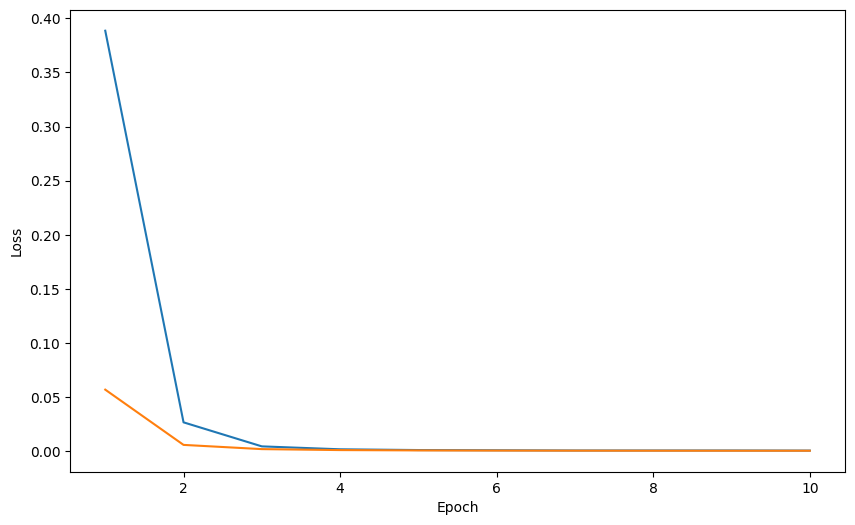

In [68]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(trainer_history_training_df["epoch"], trainer_history_training_df["loss"], label="Training Loss")
plt.plot(trainer_history_eval_df["epoch"], trainer_history_eval_df["eval_loss"], label="eval Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# ***PUSH to HUB***

In [70]:
model_upload_url = trainer.push_to_hub(
    commit_message="food vs nonfood classifier",
    token = HF_TOKEN_MASTER
)
print(f"[INFO] Model successfully uploaded to the hub with url: {model_upload_url}")

No files have been modified since last commit. Skipping to prevent empty commit.


[INFO] Model successfully uploaded to the hub with url: https://huggingface.co/tanvircr7/learn_hf_food_not_food_text_classifier-distilbert-base-uncased/tree/main/
